# Diversity VS Performances

This notebook quantify the importance of diversity compare to performances.

Results are explained in Section 4.6.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from utils import compute_shap_similarity_pearson, load_nested_results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import average_precision_score
from scipy.stats import rankdata

In [3]:
all_results = load_nested_results("results")

In [4]:
dataset_names = list(all_results.keys())
models_names = sorted(list(all_results[dataset_names[0]].keys() - {"ground_truth"}))

2_annthyroid
VIF: 1.0


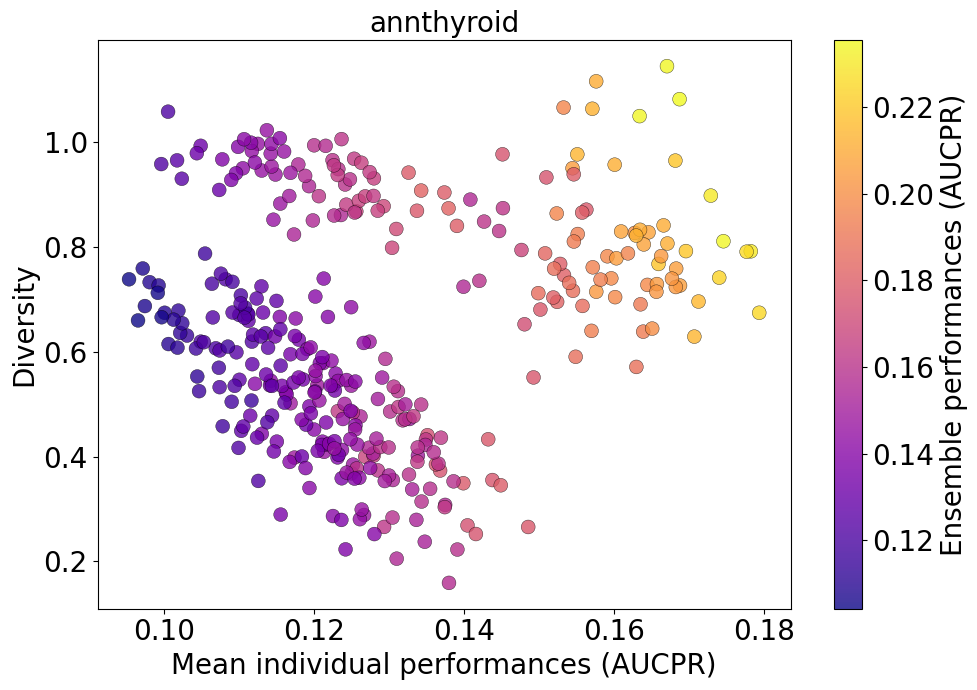

4_breastw
VIF: 1.3


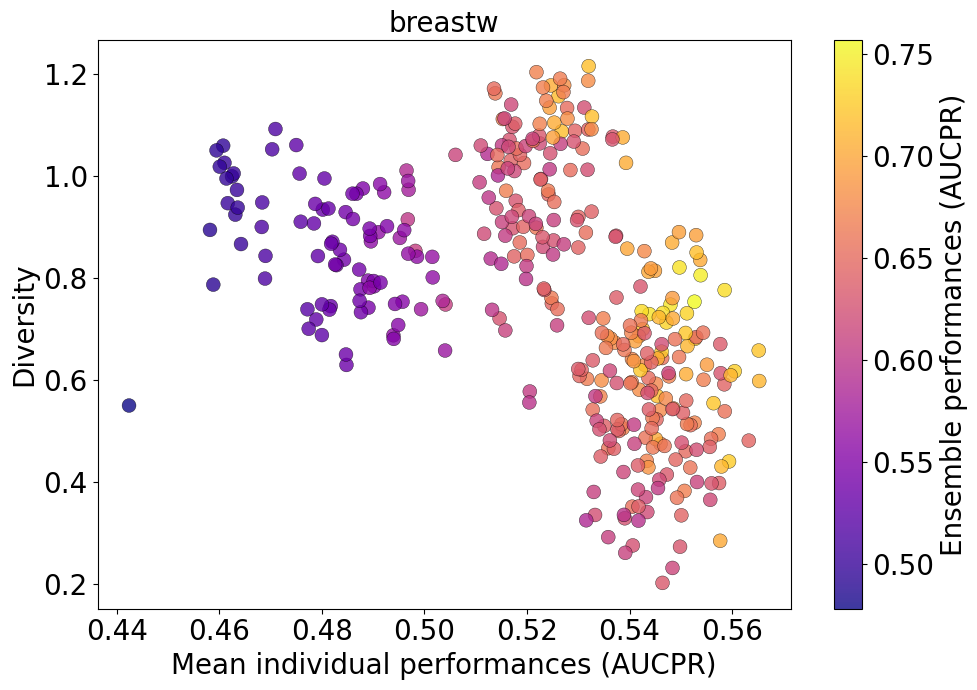

14_glass
VIF: 1.1


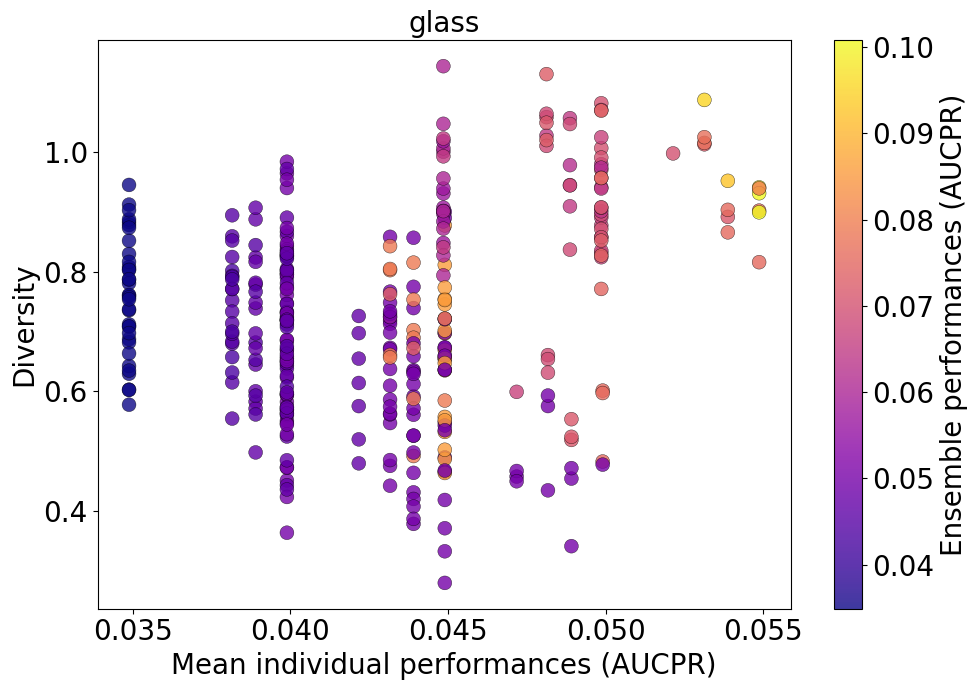

15_Hepatitis
VIF: 1.7


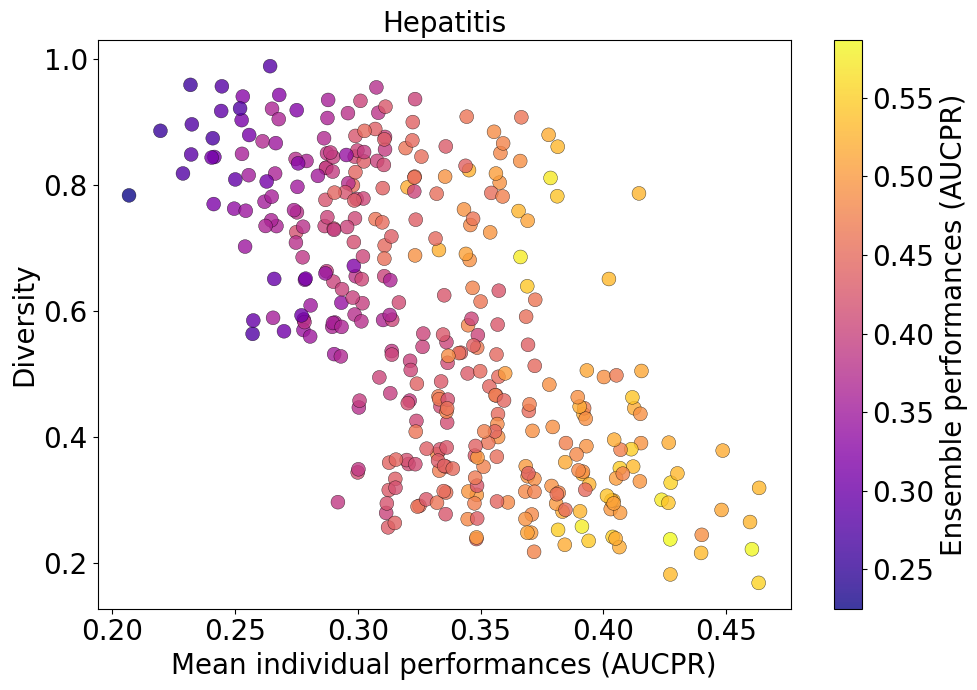

21_Lymphography
VIF: 2.3


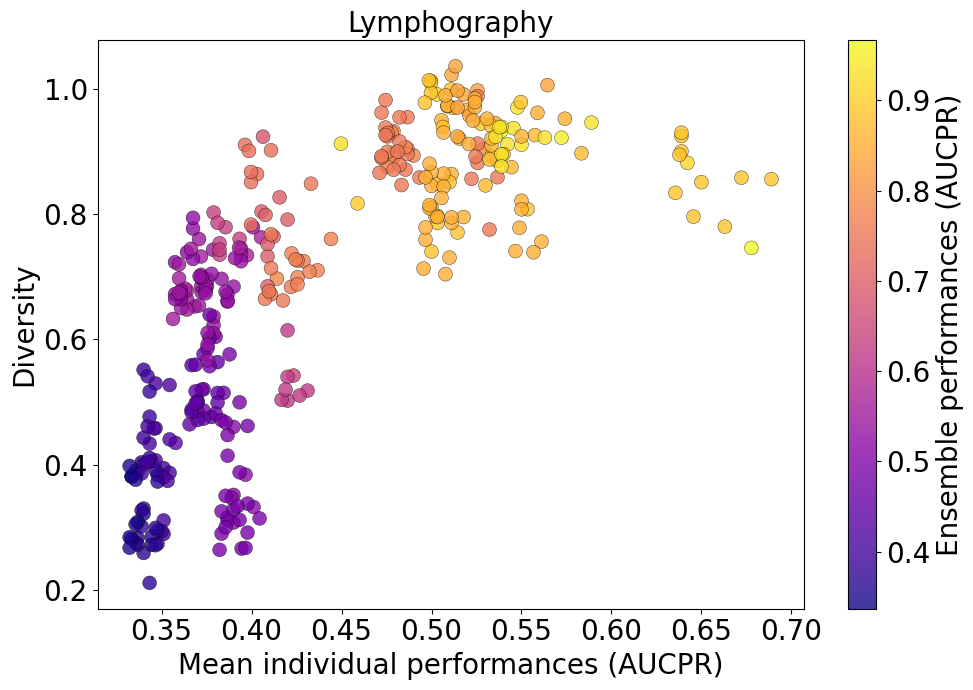

23_mammography
VIF: 1.1


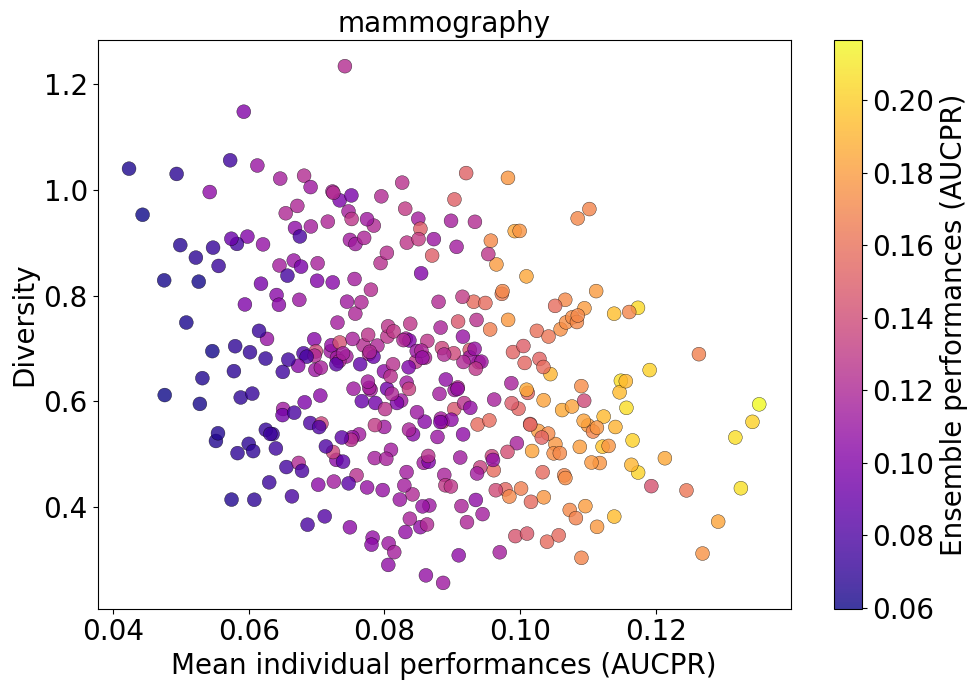

27_PageBlocks
VIF: 1.0


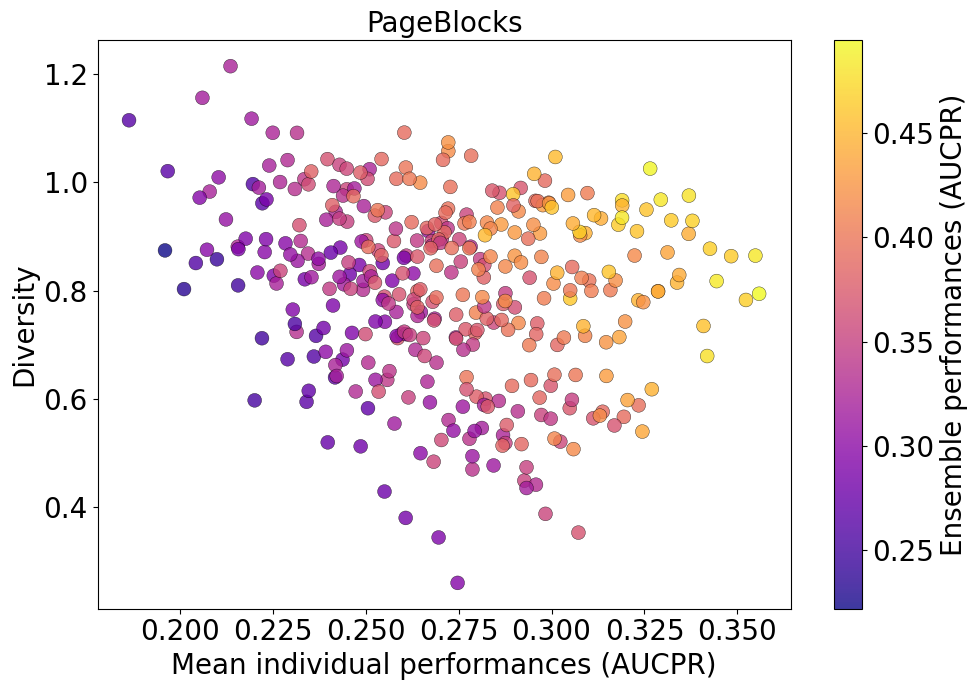

29_Pima
VIF: 1.1


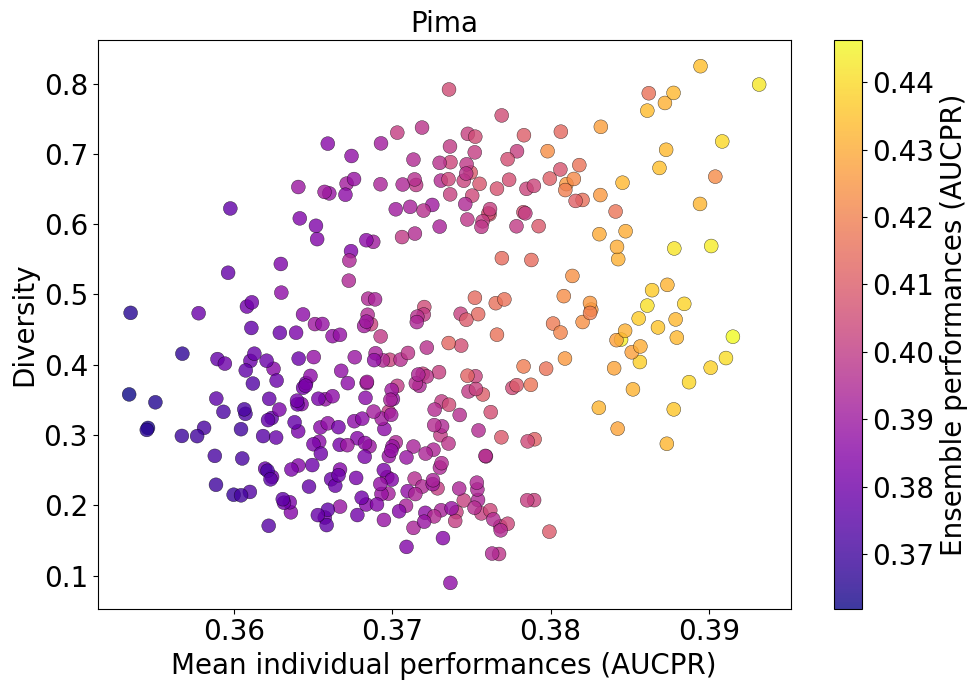

37_Stamps
VIF: 1.3


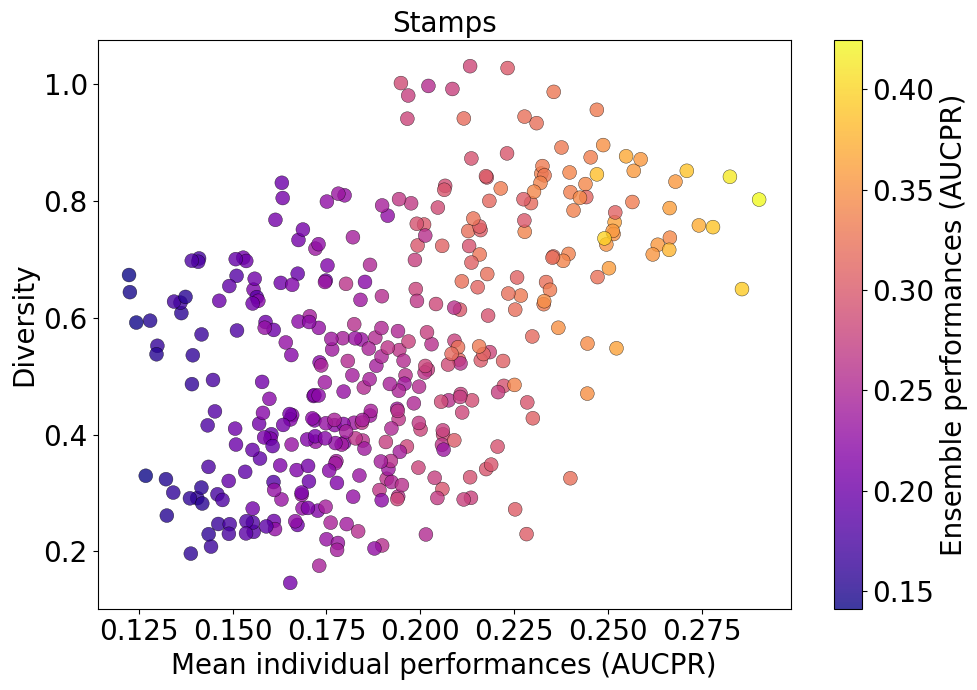

38_thyroid
VIF: 1.3


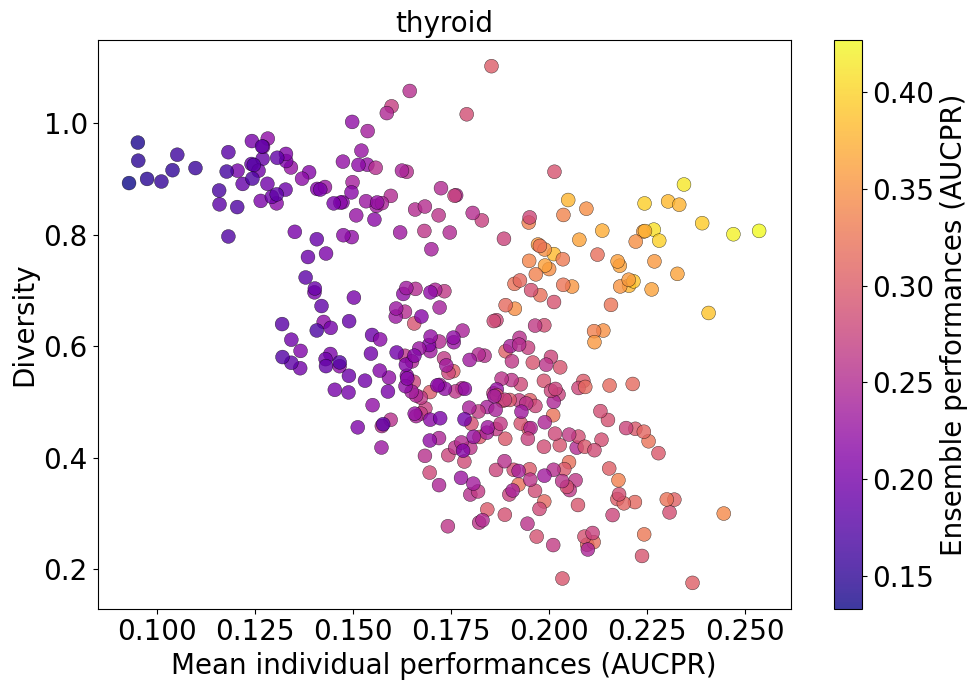

39_vertebral
VIF: 1.0


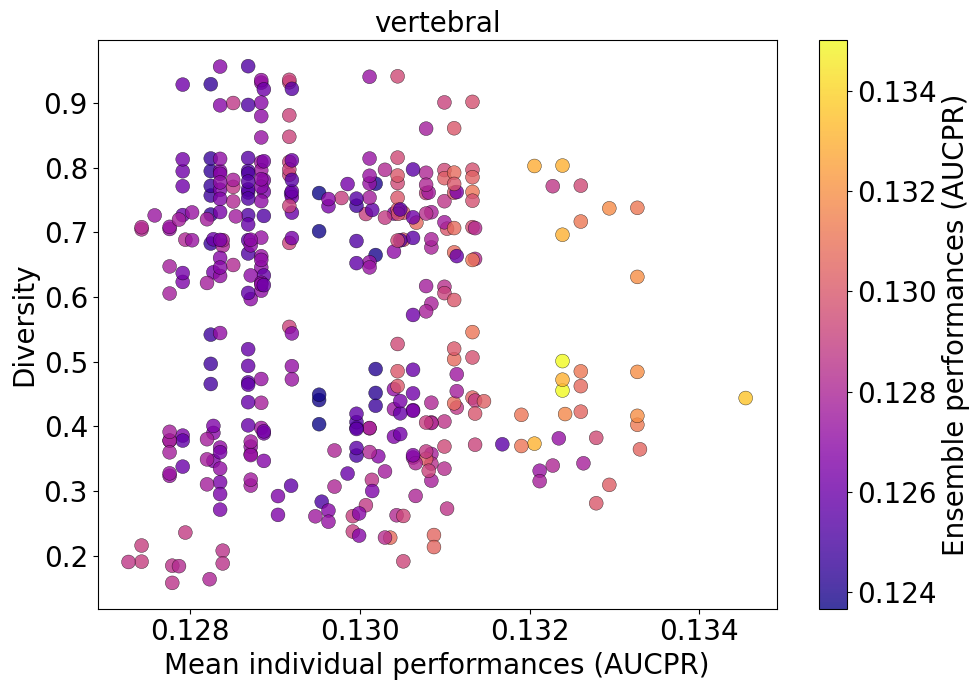

40_vowels


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

res = {}

for dataset in dataset_names:
    print(dataset)
    results = all_results[dataset]

    dist_matrix = 1 - compute_shap_similarity_pearson(all_results[dataset])[0]

    y_true_per_fold = {}
    scores_per_fold = {}

    valid_folds = []

    for fold in range(5):
        y_true = results["ground_truth"][fold]

        if len(np.unique(y_true)) < 2:
            continue

        valid_folds.append(fold)
        y_true_per_fold[fold] = y_true
        scores_per_fold[fold] = []

        for model_name in models_names:
            scores_per_fold[fold].append(results[model_name][fold]["predictions"])

    avg_individual_aucs = np.zeros(len(models_names))
    for i in range(len(models_names)):
        aucs = []
        for fold in valid_folds:
            auc = average_precision_score(
                y_true_per_fold[fold], scores_per_fold[fold][i]
            )
            aucs.append(auc)
        avg_individual_aucs[i] = np.nanmean(aucs)

    data_plot = []

    for combo in combinations(np.arange(len(models_names)), 3):
        combo = list(combo)

        avg_perf = np.mean(avg_individual_aucs[combo])

        pairs = list(combinations(combo, 2))
        avg_diversity = np.mean([dist_matrix[p[0], p[1]] for p in pairs])

        ensemble_gains = []
        for fold in valid_folds:
            y_true_fold = y_true_per_fold[fold]

            current_scores = np.array([scores_per_fold[fold][m_idx] for m_idx in combo])

            ranks = np.array([rankdata(s) for s in current_scores])
            mean_ranks = np.mean(ranks, axis=0)

            ensemble_auc = average_precision_score(y_true_fold, mean_ranks)

            gain = ensemble_auc
            ensemble_gains.append(gain)

        avg_ensemble_gain = np.mean(ensemble_gains)

        data_plot.append(
            {
                "Avg_Individual_Perf": avg_perf,
                "Diversity": avg_diversity,
                "Ensemble_Gain": avg_ensemble_gain,
            }
        )

    df = pd.DataFrame(data_plot)
    res[dataset] = df

    X = df["Avg_Individual_Perf"].values
    Y = df["Diversity"].values

    # Compute VIF
    predictors = df[["Avg_Individual_Perf", "Diversity"]]

    predictors["intercept"] = 1
    vif_data = pd.DataFrame()
    vif_data["feature"] = predictors.columns
    vif_data["VIF"] = [
        variance_inflation_factor(predictors.values, i)
        for i in range(len(predictors.columns))
    ]

    print(f"VIF: {vif_data.values[0][1]:.2}")

    fig = plt.figure(figsize=(10, 7))

    # Scatter Plot
    scatter = plt.scatter(
        df["Avg_Individual_Perf"],
        df["Diversity"],
        c=df["Ensemble_Gain"],
        cmap="plasma",
        s=100,
        alpha=0.8,
        edgecolors="k",
        linewidth=0.3,
    )

    cbar = plt.colorbar(scatter)
    cbar.set_label("Ensemble performances (AUCPR)", fontsize=20)
    cbar.ax.tick_params(labelsize=20)

    plt.xlabel("Mean individual performances (AUCPR)", fontsize=20)
    plt.ylabel("Diversity", fontsize=20)
    plt.title(f"{dataset.split("_")[1]}", fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)

    # fig.savefig(f"paper/img/{dataset}.eps", format="eps", bbox_inches="tight", pad_inches=0.1)

    plt.tight_layout()
    plt.show()

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

lr_res = {}

for name, r in res.items():

    X = r[["Avg_Individual_Perf", "Diversity"]]
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    y = r["Ensemble_Gain"]

    X_scaled = sm.add_constant(X_scaled)
    model = sm.OLS(y.values, X_scaled).fit()

    lr_res[name] = [model.params["Avg_Individual_Perf"], model.params["Diversity"]]

In [ ]:
import pandas as pd

df = pd.DataFrame(lr_res, index=["Avg_Individual_Perf", "Diversity"]).T
df["Avg_Individual_Perf"] *= 100
df["Diversity"] *= 100
df["Ratio"] = df["Diversity"] / df["Avg_Individual_Perf"]

df.round(1)

In [ ]:
df.mean().round(1)